# Dataset Exploratory Analysis & Complexity Assessment

This notebook provides a comprehensive analysis of the **Iris**, **Wine**, and **Breast Cancer** datasets. 
The goal is to understand the feature distributions, correlations, and inherent classification complexity of each dataset before applying Genetic Algorithm-optimized Decision Trees.

## Table of Contents
1. [Setup and Data Loading](#1.-Setup-and-Data-Loading)
2. [Feature Distributions & Class Balance](#2.-Feature-Distributions-&-Class-Balance)
3. [Correlation Analysis](#3.-Correlation-Analysis)
4. [Complexity Visualization (PCA + Decision Boundaries)](#4.-Complexity-Visualization)
5. [Comparative Conclusion](#5.-Comparative-Conclusion)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Set Plotting Style
sns.set(style="whitegrid", context="notebook", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Setup and Data Loading

We use a helper function to load datasets into Pandas DataFrames for easier analysis.

In [2]:
def load_dataset_as_df(loader_func, name):
    data = loader_func()
    df = pd.DataFrame(data.data, columns=data.feature_names)
    df['target'] = data.target
    # Map target indices to names if available
    if hasattr(data, 'target_names'):
        df['class'] = df['target'].map(lambda x: data.target_names[x])
    else:
        df['class'] = df['target'].astype(str)
    return df, data, name

# Load all 3 datasets
iris_df, iris_data, iris_name = load_dataset_as_df(load_iris, "Iris")
wine_df, wine_data, wine_name = load_dataset_as_df(load_wine, "Wine")
cancer_df, cancer_data, cancer_name = load_dataset_as_df(load_breast_cancer, "Breast Cancer")

datasets = [
    (iris_df, iris_name),
    (wine_df, wine_name),
    (cancer_df, cancer_name)
]

for df, name in datasets:
    print(f"{name}: {df.shape[0]} samples, {df.shape[1]-2} features, {df['target'].nunique()} classes")

Iris: 150 samples, 4 features, 3 classes
Wine: 178 samples, 13 features, 3 classes
Breast Cancer: 569 samples, 30 features, 2 classes


## 2. Feature Distributions & Class Balance

Understanding class balance is critical. Imbalanced datasets (like Breast Cancer might be) can bias models toward the majority class.
Boxplots help us identify features with different scales or outliers.

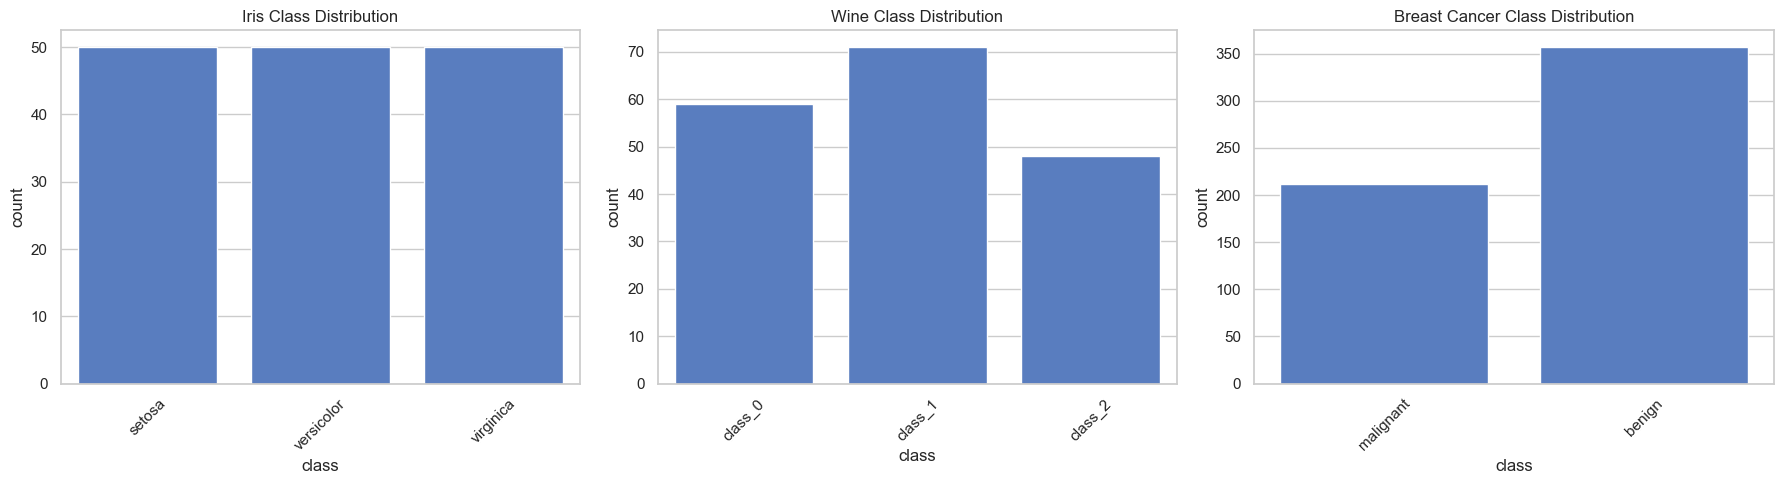

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (df, name) in enumerate(datasets):
    sns.countplot(data=df, x='class', ax=axes[idx])
    axes[idx].set_title(f"{name} Class Distribution")
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

> **Observations:**
> - **Iris**: Perfectly balanced (50 samples per class).
> - **Wine**: Imbalanced. Class 1 (index 1) has more samples than Class 0 or 2.
> - **Breast Cancer**: Significant imbalance. 'Benign' cases outnumber 'Malignant' cases roughly 2:1.

### Feature Scales (Boxplots)
We investigate the scale of features. Large disparities in scale (common in Wine and Cancer) suggest that normalization (StandardScaler) is important for distance-based methods or PCA.

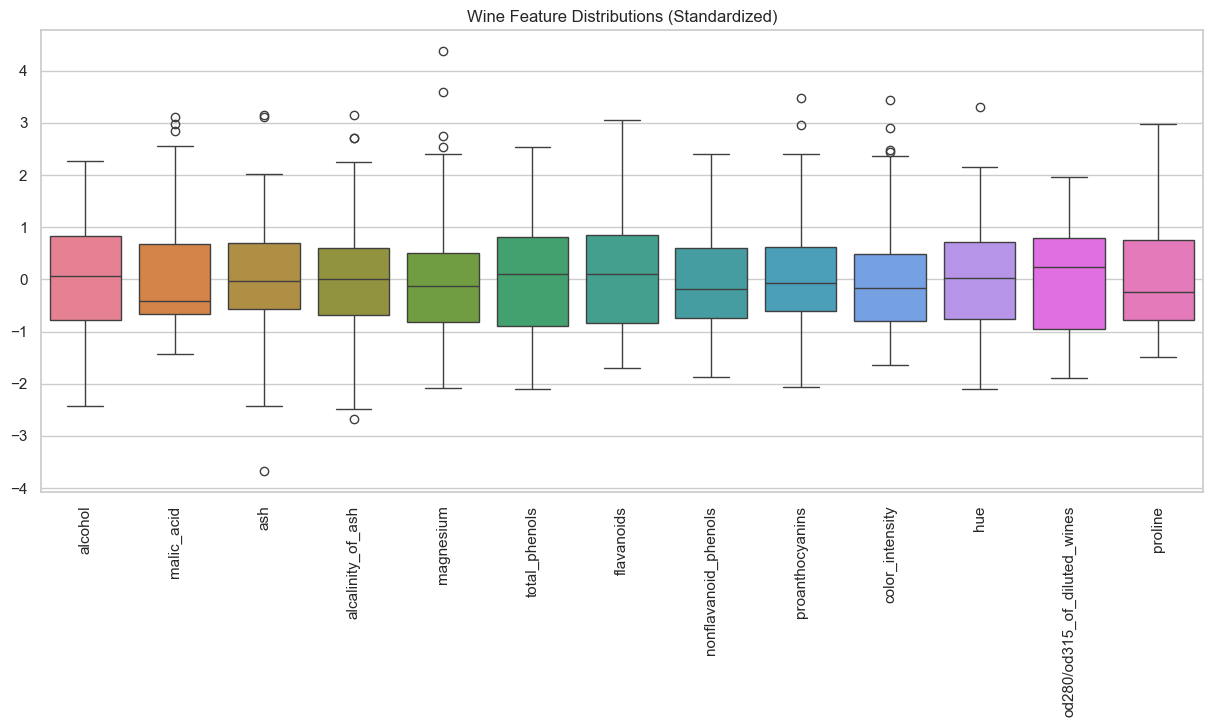

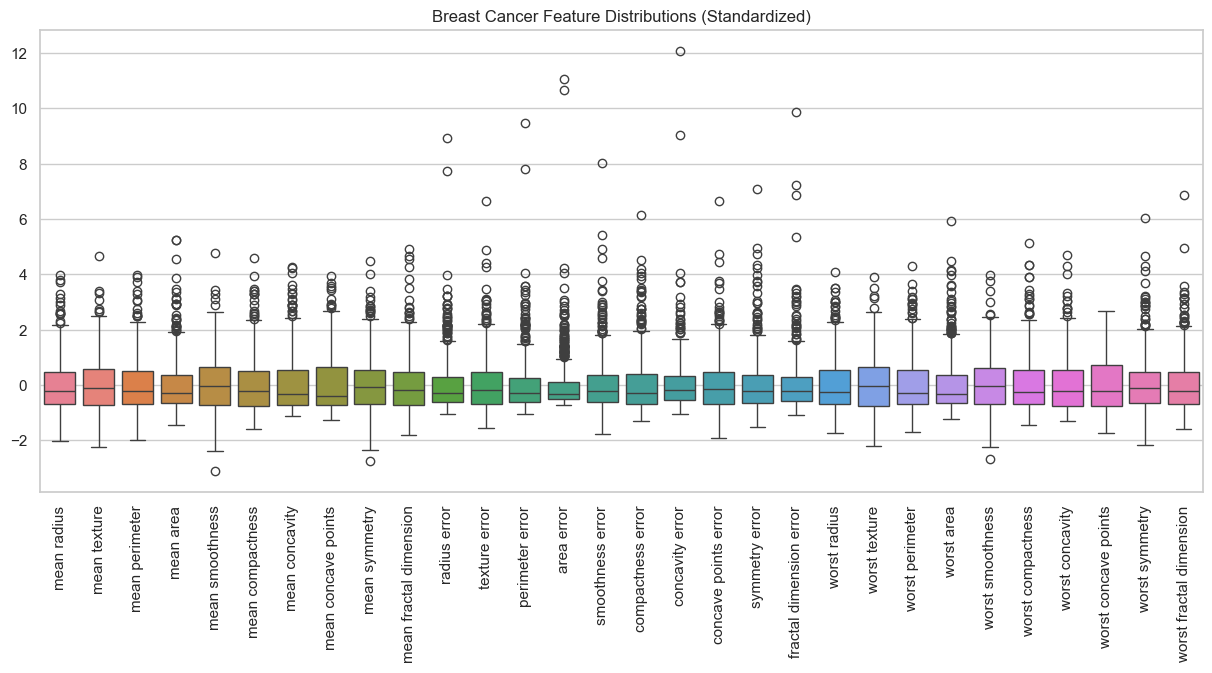

In [4]:
def plot_distributions(df, name):
    # Select only numeric feature columns
    feature_cols = [c for c in df.columns if c not in ['target', 'class']]
    
    # Normalize for visualization if scales are wildly different
    df_std = pd.DataFrame(StandardScaler().fit_transform(df[feature_cols]), columns=feature_cols)
    
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=df_std)
    plt.title(f"{name} Feature Distributions (Standardized)")
    plt.xticks(rotation=90)
    plt.show()

plot_distributions(wine_df, "Wine")
plot_distributions(cancer_df, "Breast Cancer")

## 3. Correlation Analysis

Highly correlated features provide redundant information. Decision trees can handle colinearity well, but understanding it helps us interpret which features might be interchangeable.

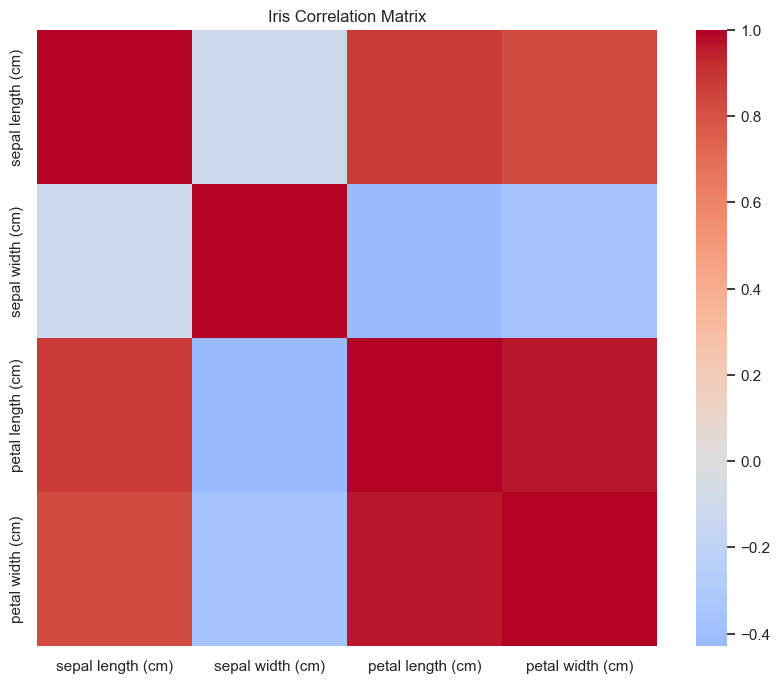

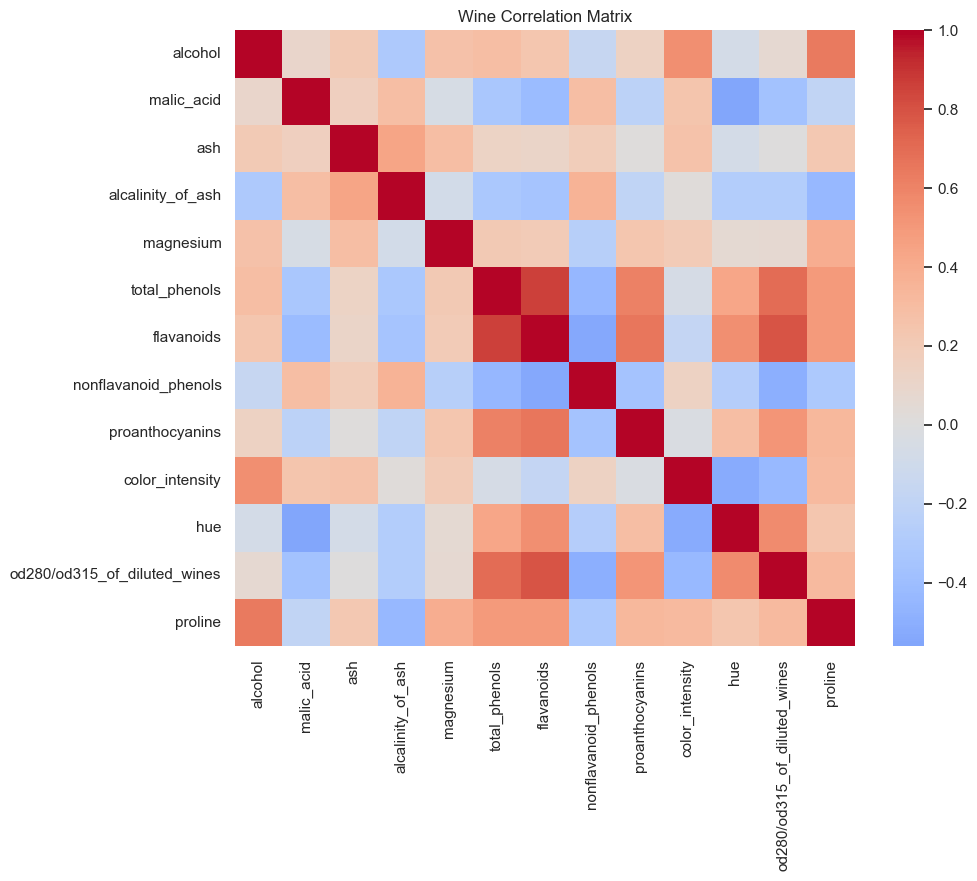

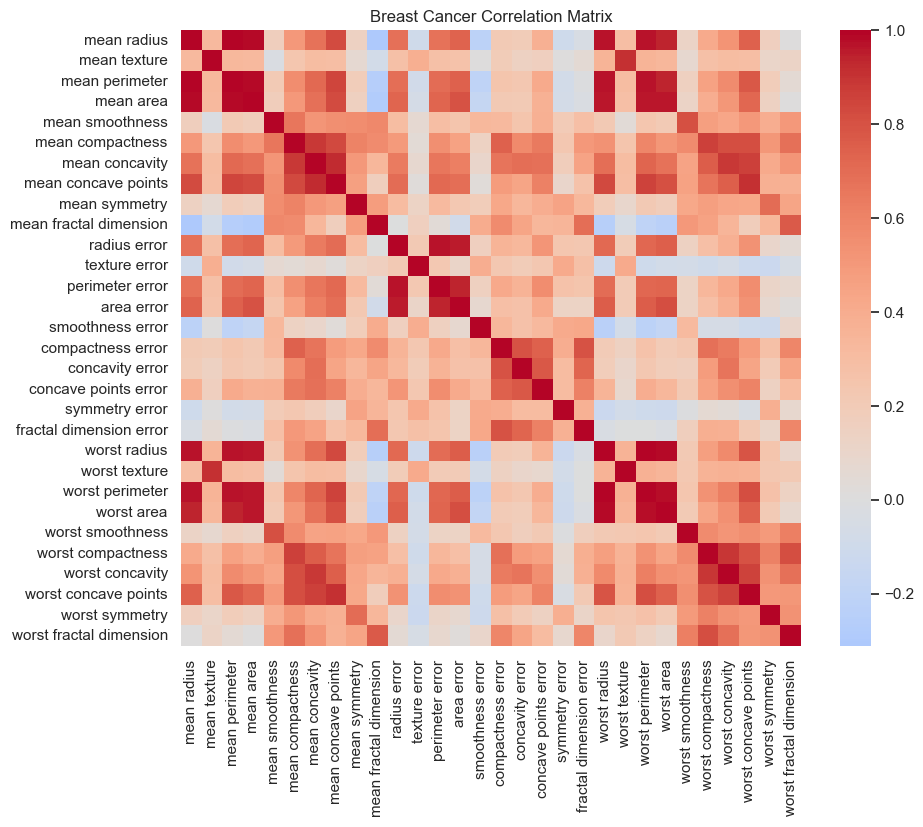

In [5]:
def plot_correlation(df, name):
    feature_cols = [c for c in df.columns if c not in ['target', 'class']]
    corr = df[feature_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, fmt='.1f')
    plt.title(f"{name} Correlation Matrix")
    plt.show()

plot_correlation(iris_df, "Iris")
plot_correlation(wine_df, "Wine")
plot_correlation(cancer_df, "Breast Cancer")

> **Observations:**
> - **Iris**: Petal Length and Petal Width are extremely highly correlated (> 0.95), suggesting either one alone is a strong predictor.
> - **Breast Cancer**: Many features (radius, perimeter, area) are geometrically related and thus highly correlated. The dataset has high redundancy.

## 4. Complexity Visualization (PCA + Decision Boundaries)

To visualize how "hard" these classification problems are, we project the high-dimensional data into **2D** using PCA.
Then, we fit a simple Decision Tree to this 2D projection to visualize the decision boundaries.

- **Simpler boundaries** = Easier dataset.
- **Fragmented/Complex boundaries** = Harder dataset (more overlap).

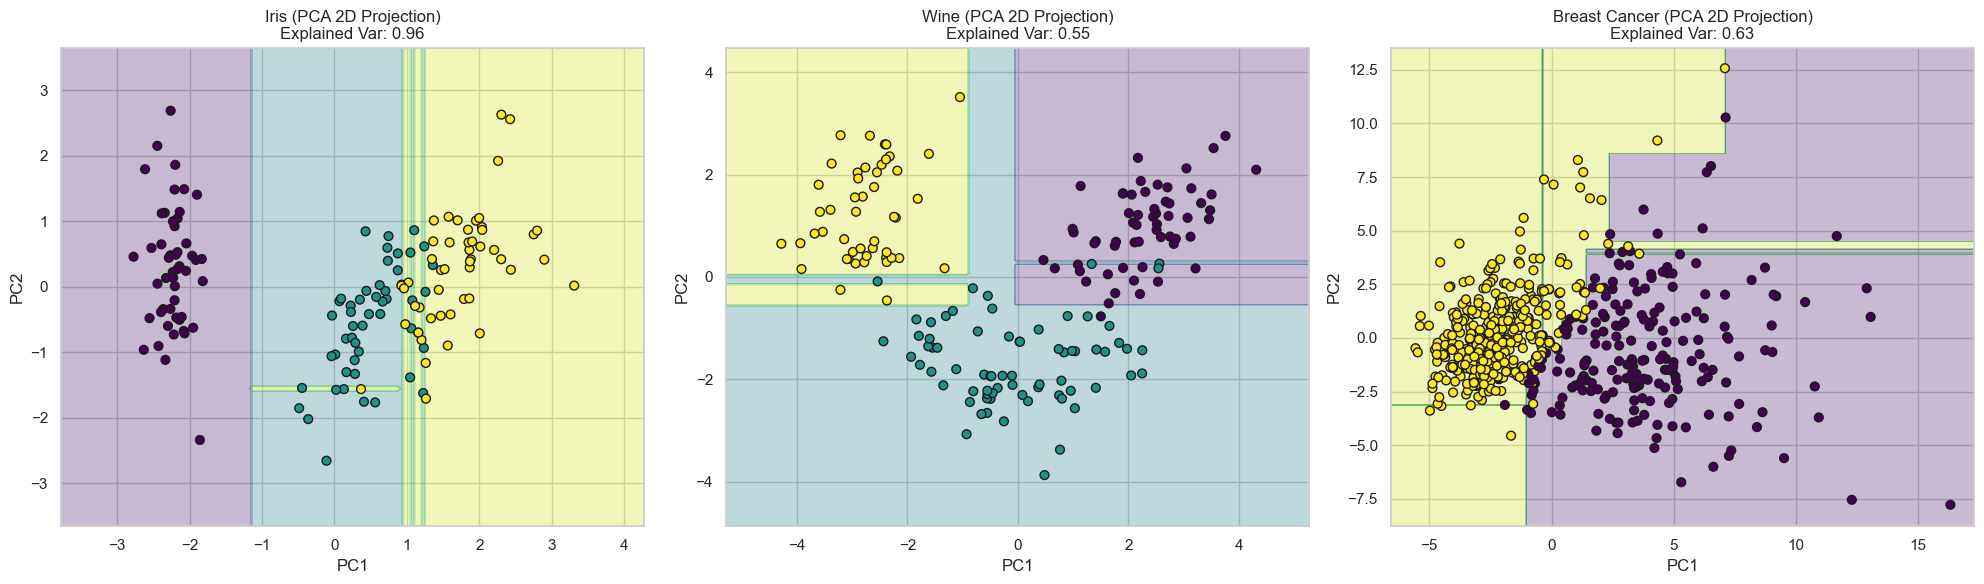

In [6]:
def plot_decision_boundary(df, name, ax):
    # 1. Prepare Data
    X = df.drop(columns=['target', 'class']).values
    y = df['target'].values
    
    # 2. PCA Reduction to 2D
    X_std = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_std)
    
    # 3. Train a Proxy Tree on the 2D data
    # We aim for a somewhat detailed tree (depth=5) to show where it struggles
    clf = DecisionTreeClassifier(max_depth=5, random_state=42)
    clf.fit(X_pca, y)
    
    # 4. Create Meshgrid
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))
    
    # 5. Predict
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 6. Plot
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
    ax.set_title(f"{name} (PCA 2D Projection)\nExplained Var: {pca.explained_variance_ratio_.sum():.2f}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plot_decision_boundary(iris_df, "Iris", axes[0])
plot_decision_boundary(wine_df, "Wine", axes[1])
plot_decision_boundary(cancer_df, "Breast Cancer", axes[2])
plt.tight_layout()
plt.show()

## 5. Comparative Conclusion

| Dataset | Samples | Features | Classes | Difficulty | Modeling Implications |
|---------|---------|----------|---------|------------|-----------------------|
| **Iris** | 150 | 4 | 3 | **Low** | Almost linearly separable. A very shallow tree (depth 2-3) should achieve >95% accuracy. Good for sanity checking the GA. |
| **Wine** | 178 | 13 | 3 | **Medium** | Classes are fairly distinct in PCA space, but higher dimensionality (13 features) increases search space for the GA. |
| **Cancer** | 569 | 30 | 2 | **High** | High dimensionality (30 features) and some overlap between benign/malignant classes in projection. Requires effective feature selection (which GA Trees do inherently). |

### Implications for GA-Tree Optimization
1.  **Search Space**: For Breast Cancer, the mutation operator needs to explore 30 possible feature splits, requiring a larger population or more generations compared to Iris.
2.  **Regularization**: The "High" difficulty datasets are prone to overfitting. The Fitness Function must heavily penalize tree size to ensure the GA doesn't just produce massive trees.